In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import *
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [29]:
data_path = 'data/'

air_reserve = pd.read_csv(data_path + 'air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(data_path + 'air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(data_path + 'air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv(data_path + 'date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [30]:
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek

In [31]:
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)

In [6]:
air_store['air_genre_name'].nunique()

14

In [7]:
air_store['air_genre_name'] = air_store['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))

In [8]:
air_store

,store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
827,air_7514d90009613cd6,Karaoke Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956


In [9]:
air_store

,store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
827,air_7514d90009613cd6,Karaoke Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956


In [10]:
air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])
air_store

,store_id,air_genre_name,air_area_name,latitude,longitude,air_area_name0
0,air_0f0cdeee6c9bf3d7,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken
1,air_7cc17a324ae5c7dc,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken
2,air_fee8dcf4d619598e,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken
3,air_a17f0778617c76e2,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,Hyōgo-ken
4,air_83db5aff8f50478e,Italian French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to
...,...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Tōkyō-to
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Tōkyō-to
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Tōkyō-to
827,air_7514d90009613cd6,Karaoke Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,Hokkaidō


In [11]:
genre_counts = air_store['air_genre_name'].value_counts()
fig = plt.figure(figsize = (12, 8))
genre_counts.plot.bar(x = 'air_genre_name')

<AxesSubplot:>

C:\Users\kwansu\anaconda3\envs\tf_opencv\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


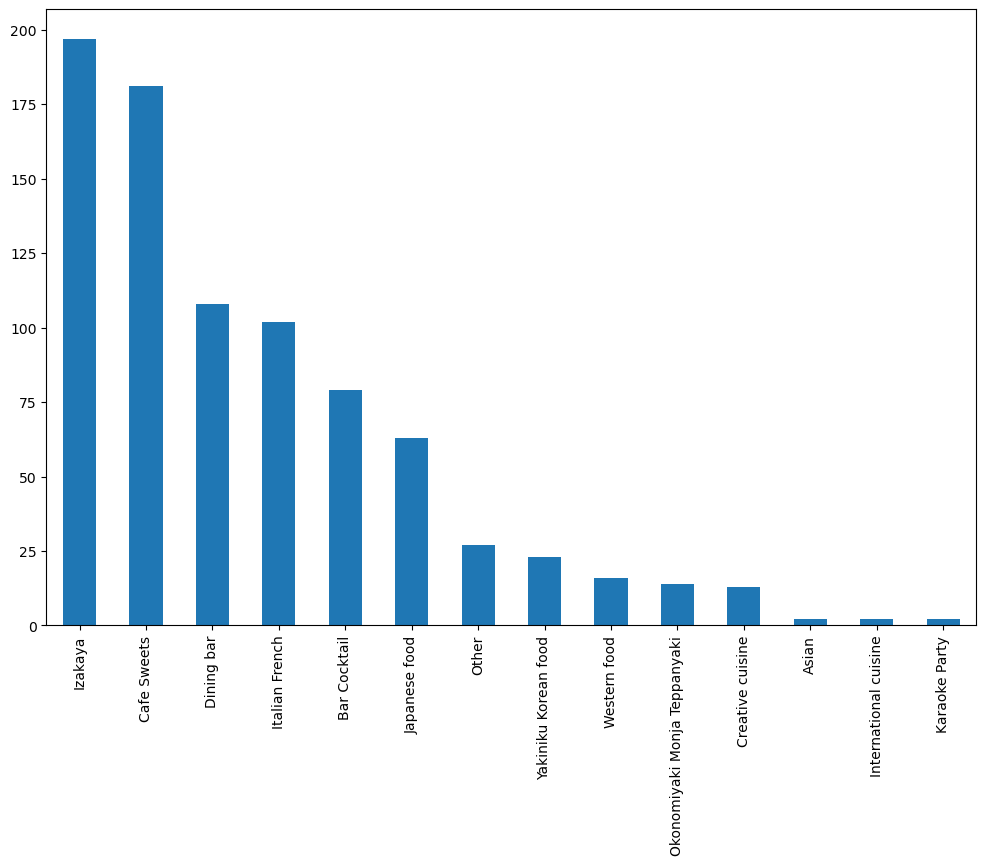

<Figure size 1200x800 with 0 Axes>

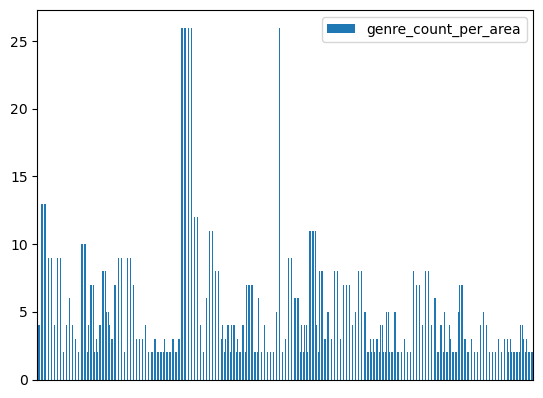

In [12]:
air_store['genre_count_per_area'] = air_store.groupby(['air_genre_name','air_area_name'])['store_id'].transform('count')
fig = plt.figure(figsize = (12, 8))
air_store.plot.bar(x='air_area_name', y='genre_count_per_area', rot=0)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.show()

In [56]:
air_store['restaurants_per_area'] = air_store.groupby(['air_area_name'])['store_id'].transform('count')
air_store

,store_id,air_genre_name,air_area_name,latitude,longitude,restaurants_per_area
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,17
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,17
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,17
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,17
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,51
...,...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,58
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,58
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,58
827,air_7514d90009613cd6,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,21


C:\Users\kwansu\anaconda3\envs\tf_opencv\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1200x800 with 0 Axes>

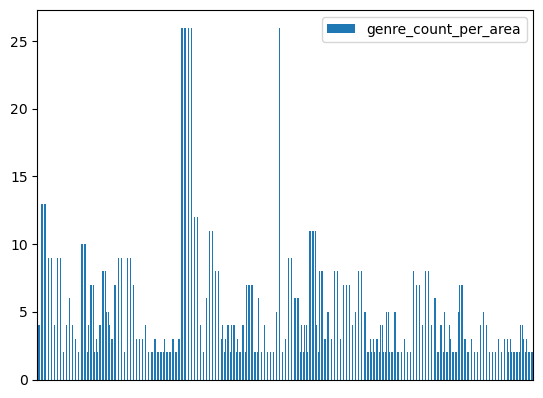

In [14]:

fig = plt.figure(figsize = (12, 8))
air_store.plot.bar(x='air_area_name', y='genre_count_per_area', rot=0)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.show()

In [15]:
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

#골든 위크
date_info['golden_week'] = (((date_info['visit_date'].str[5:7] == '04') & (date_info['visit_date'].str[8:10].isin(['29','30']))) |\
                            ((date_info['visit_date'].str[5:7]== '05') & (date_info['visit_date'].str[8:10].isin(['01','02', '03', '04', '05'])))|
                           ((date_info['visit_date'].str[0:5]== '2017') & (date_info['visit_date'].str[5:7]== '05') & (date_info['visit_date'].str[8:10].isin(['06','07'])))).astype(int)
                                                                                                                                                              

data = pd.concat([air_visit, submission]).copy()
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2','golden_week']], on=['visit_date'],how='left')

In [16]:
import math 

In [17]:
data['air_store_id2'] = lbl.fit_transform(data['store_id'])
data['month'] = pd.to_datetime(date_info['visit_date']).dt.month

In [18]:
data['id_dow_visitor_max']= data.groupby(['store_id', 'dow'])['visitors'].transform(max)
data['id_dow_visitor_min']= data.groupby(['store_id', 'dow'])['visitors'].transform(min)
data['id_dow_visitor_mean']= data.groupby(['store_id', 'dow'])['visitors'].transform(np.mean)
data['id_dow_visitor_std']= data.groupby(['store_id', 'dow'])['visitors'].transform(np.std)

In [19]:
data['genre_dow_visitor_min']= data.groupby(['air_genre_name', 'dow'])['visitors'].transform(min)
data['genre_dow_visitor_max']= data.groupby(['air_genre_name', 'dow'])['visitors'].transform(max)
data['genre_dow_visitor_mean']= data.groupby(['air_genre_name', 'dow'])['visitors'].transform(np.mean)

In [20]:
def search_outlier(df, q=0.25, a=1.5):
    quartile_1 = df.quantile(q)
    quartile_3 = df.quantile(1-q)
    IQR = quartile_3 - quartile_1
    search_df = df[(df < (quartile_1 - a * IQR)) | (df > (quartile_3 + a * IQR))]
    return search_df

In [21]:
store_ids = air_visit['store_id'].unique()
len(store_ids)

829

In [22]:
data[(data['visit_date'] == '2016-05-01') & (data['store_id'] == store_ids[1])]['id_dow_visitor_std']

482    0.7185
Name: id_dow_visitor_std, dtype: float64

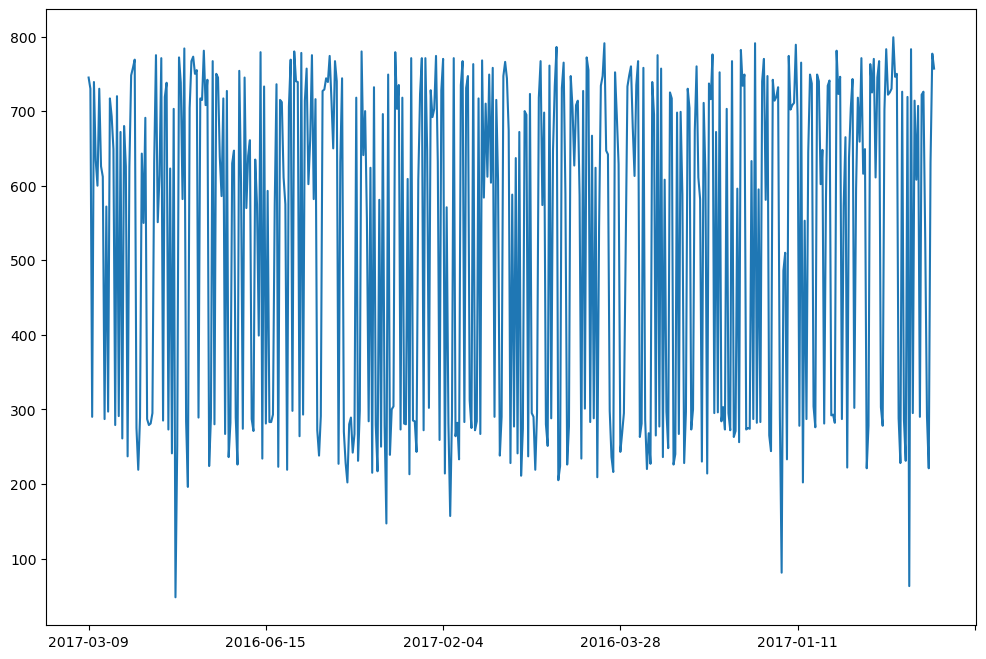

In [22]:
store_count_per_date = air_visit['visit_date'].value_counts(sort=False)
fig = plt.figure(figsize = (12, 8))
store_count_per_date.plot()
plt.show()

In [23]:
df_visit_count_per_store = pd.DataFrame()

df_visit_count_per_store['visit_date'] = np.sort(air_visit['visit_date'].unique())
for i in store_ids:
    temp = air_visit[air_visit['store_id'] == i][['visit_date', 'visitors']].rename(columns={'visitors':i})
    df_visit_count_per_store = df_visit_count_per_store.merge(temp, on='visit_date',how='left')
    #temp = air_visit[air_visit['store_id'] == air_visit['store_id'][0]]

df_visit_count_per_store

,visit_date,air_ba937bf13d40fb24,air_25e9888d30b386df,air_8e4360a64dbd4c50,air_35512c42db0868da,air_a271c9ba19e81d17,air_fd6aac1043520e83,air_64d4491ad8cdb1c6,air_cf22e368c1a71d53,air_f3f9824b7d70c3cf,...,air_e9ebf7fc520ac76a,air_7bc6ca04d7b0f3b8,air_084d98859256acf0,air_b5598d12d1b84890,air_31c753b48a657b6c,air_168441ada3e878e1,air_6c952e3c6e590945,air_0f2f96335f274801,air_c7d30ab0e07f31d5,air_24e8414b9b07decb
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN,...,14.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-05,NaN,12.0,NaN,NaN,NaN,36.0,9.0,NaN,NaN,...,6.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,2017-04-18,11.0,NaN,14.0,NaN,49.0,39.0,7.0,NaN,14.0,...,NaN,6.0,12.0,7.0,6.0,46.0,23.0,6.0,23.0,6.0
474,2017-04-19,11.0,NaN,15.0,3.0,18.0,47.0,11.0,NaN,20.0,...,15.0,8.0,16.0,4.0,21.0,49.0,6.0,6.0,18.0,6.0
475,2017-04-20,14.0,6.0,12.0,3.0,15.0,35.0,20.0,NaN,10.0,...,6.0,14.0,17.0,3.0,15.0,49.0,18.0,13.0,25.0,7.0
476,2017-04-21,40.0,2.0,14.0,5.0,32.0,56.0,22.0,NaN,17.0,...,35.0,7.0,26.0,3.0,12.0,54.0,20.0,15.0,30.0,8.0


In [57]:
data['expansion_after'] =((pd.to_datetime(data['visit_date']).dt.year >= 2016) | (pd.to_datetime(data['visit_date']).dt.month >= 7)).astype(int)

In [58]:
df_visit_count_per_store.index = df_visit_count_per_store['visit_date']

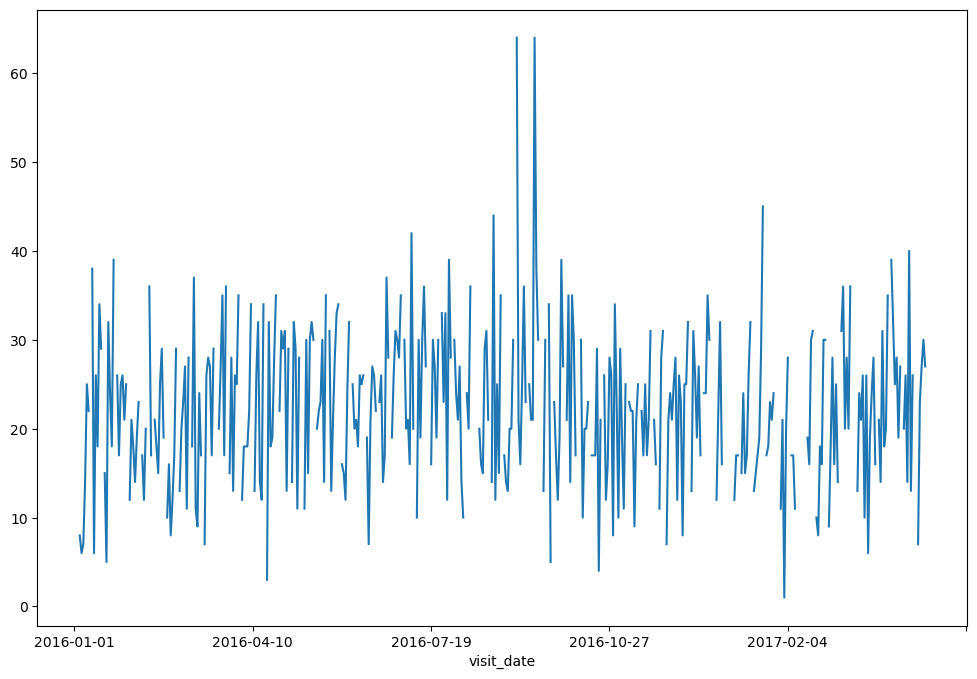

In [59]:
fig = plt.figure(figsize = (12, 8))
df_visit_count_per_store[store_ids[200]].plot()
plt.show()

In [60]:
# for i in range(len(store_ids)):
#     temp = df_visit_count_per_store[store_ids[i]]
#     df_visit_count_per_store[i] = df_visit_count_per_store[].apply(lambda x : data)
#     air_reserve['differ'] = air_reserve['differ'].apply(lambda x : x.split(" ")[0])
#     ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

In [61]:
temp = air_visit[air_visit['store_id'] == air_visit['store_id'][0]]
temp.index = temp['visit_date']
result = search_outlier(temp['visitors'])
result

visit_date
2016-07-01    61
2016-08-10    57
Name: visitors, dtype: int64

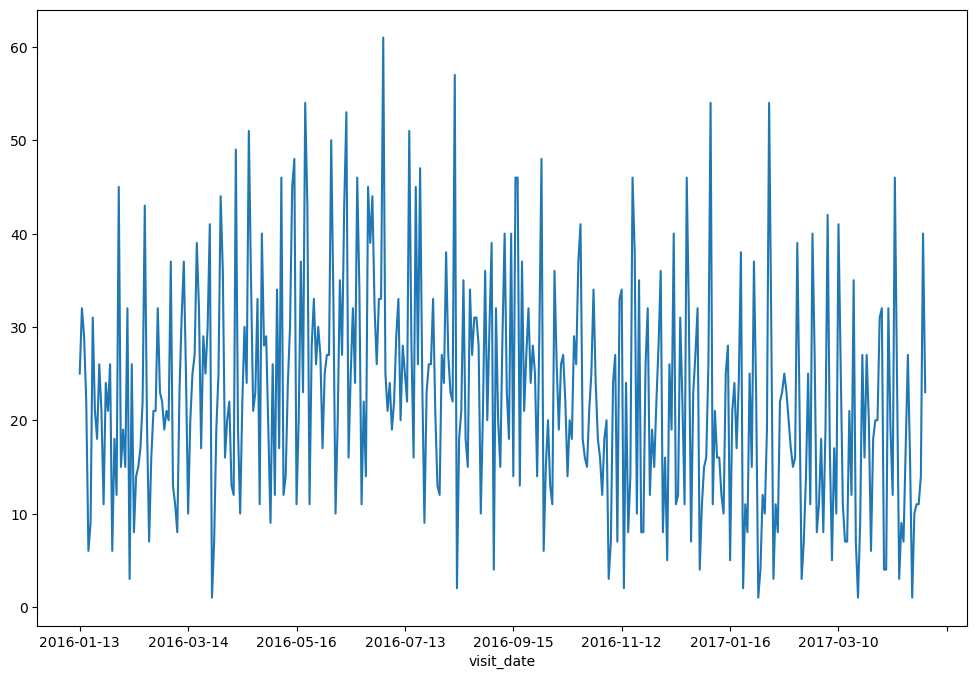

In [62]:
fig = plt.figure(figsize = (12, 8))
temp['visitors'].plot()
plt.show()

In [63]:
# for i in range(len(air_visit['store_id'])):
#     temp = air_visit[air_visit['store_id'] == store_ids[i]]
#     temp.index = temp['visit_date']
#     result = search_outlier(temp['visitors'])
#     print(result)

## 모델 구성 및 결과 예측

In [64]:
train_size = len(air_visit)
train = data[:train_size]
test = data[train_size:]

In [65]:
train.columns

Index(['store_id', 'visit_date', 'visitors', 'id', 'dow', 'air_genre_name',
       'air_area_name', 'latitude', 'longitude', 'air_area_name0',
       'genre_count_per_area', 'restaurants_per_area', 'holiday_flg',
       'holiday_flg2', 'golden_week', 'air_store_id2', 'month',
       'id_dow_visitor_max', 'id_dow_visitor_min', 'id_dow_visitor_mean',
       'id_dow_visitor_std', 'genre_dow_visitor_min', 'genre_dow_visitor_max',
       'genre_dow_visitor_mean', 'expansion_after'],
      dtype='object')

In [73]:
col = ['dow', 'air_genre_name', 'air_area_name0', 'holiday_flg', 'holiday_flg2', 'month', 'golden_week',
      'genre_dow_visitor_min', 'genre_dow_visitor_max','genre_dow_visitor_mean','id_dow_visitor_max','id_dow_visitor_min',
      'id_dow_visitor_mean','air_store_id2', 'expansion_after', 'genre_count_per_area']
col

['dow',
 'air_genre_name',
 'air_area_name0',
 'holiday_flg',
 'holiday_flg2',
 'month',
 'golden_week',
 'genre_dow_visitor_min',
 'genre_dow_visitor_max',
 'genre_dow_visitor_mean',
 'id_dow_visitor_max',
 'id_dow_visitor_min',
 'id_dow_visitor_mean',
 'air_store_id2',
 'expansion_after',
 'genre_count_per_area']

In [74]:
import lightgbm as lgb

In [75]:
params = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.7,
    'num_leaves': 60,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
}

In [76]:
lgb_train = lgb.Dataset(train[col], train['visitors'])
lgb_test = lgb.Dataset(test[col], test['visitors'])

gbm = lgb.train(params,lgb_train,2300)
pred = gbm.predict(test[col])

In [77]:
test['visitors'] = np.expm1(pred)

C:\Users\kwansu\anaconda3\envs\tf_opencv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
sub = test[['id','visitors']].copy()
sub.to_csv('submission3.csv', index=False)

## 이상치 제거(하는중)

In [79]:
def diff_of_days(day1, day2):
    days = (parse(day1[:10]) - parse(day2[:10])).days
    return days

In [80]:
air_reserve

,store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date,dow
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,2016-01-01,4
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,2016-01-01,4
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,2016-01-01,4
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,2016-01-01,4
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,2016-01-01,4
...,...,...,...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6,2017-05-29,2017-04-17,0
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8,2017-05-30,2017-04-19,1
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3,2017-05-31,2017-04-12,2
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10,2017-05-31,2017-04-19,2


In [ ]:
from datetime import datetime

air_reserve['differ']  = pd.to_datetime(air_reserve['visit_date']) - pd.to_datetime(air_reserve['reserve_date'])

In [ ]:
air_reserve['differ'] = air_reserve['differ'].astype(str)
air_reserve['differ'] = air_reserve['differ'].apply(lambda x : x.split(" ")[0])

In [ ]:
air_reserve['differ'] = air_reserve['differ'].astype(int)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
ax = sns.countplot(air_reserve['differ'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

In [ ]:
famous_res_id = air_reserve[air_reserve['differ'] > 300]['store_id'].unique()

In [ ]:
famous_res_id

In [ ]:
air_reserve[(air_reserve['differ'] > 300) & (air_reserve['store_id'] == 'air_a17f0778617c76e2')]

In [ ]:
data[(data['store_id'] == 'air_a17f0778617c76e2') & (data['visit_date'] == '2016-11-11')]

In [ ]:
data[(data['store_id'] == 'air_a17f0778617c76e2') & (data['visit_date'] == '2016-11-11')]

In [ ]:
data[data['store_id'] == 'air_a17f0778617c76e2'].groupby(['visit_date'])['visitors'].sum().plot()

In [ ]:
air_visit[air_visit['store_id'].isin(famous_res_id)].groupby('store_id')['visitors'].sum()

In [ ]:
air_visit.groupby('store_id')['visitors'].sum().sort_values().describe()

In [ ]:
data[data['store_id'] == "air_a17f0778617c76e2"]

In [ ]:
air_reserve[air_reserve['store_id'].isin(famous_res_id)]

## 4.2 Air Store


In [32]:
genre_counts = air_store['air_genre_name'].value_counts()
genre_counts

Izakaya                         197
Cafe/Sweets                     181
Dining bar                      108
Italian/French                  102
Bar/Cocktail                     79
Japanese food                    63
Other                            27
Yakiniku/Korean food             23
Western food                     16
Okonomiyaki/Monja/Teppanyaki     14
Creative cuisine                 13
Asian                             2
Karaoke/Party                     2
International cuisine             2
Name: air_genre_name, dtype: int64

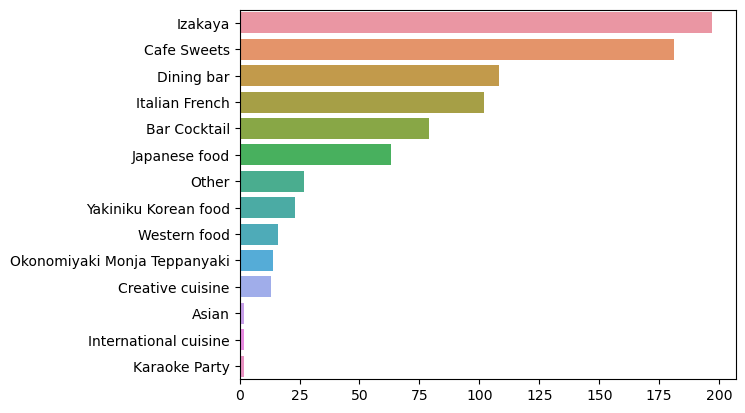

In [57]:
import seaborn as sns

sns.barplot(y= genre_counts.index, x= genre_counts.values)
plt.show()

In [99]:
restaurants_per_area = air_store['air_area_name']
restaurants_per_area.index = air_store['air_genre_name']

restaurants_per_area = restaurants_per_area.value_counts()
restaurants_per_area

Fukuoka-ken Fukuoka-shi Daimyō        64
Tōkyō-to Shibuya-ku Shibuya           58
Tōkyō-to Minato-ku Shibakōen          51
Tōkyō-to Shinjuku-ku Kabukichō        39
Tōkyō-to Setagaya-ku Setagaya         30
                                      ..
Tōkyō-to Chiyoda-ku Kanda Jinbōchō     2
Tōkyō-to Meguro-ku Jiyūgaoka           2
Tōkyō-to Musashino-shi Midorichō       2
Fukuoka-ken Fukuoka-shi Tenjin         2
Tōkyō-to Kōtō-ku Tomioka               2
Name: air_area_name, Length: 103, dtype: int64

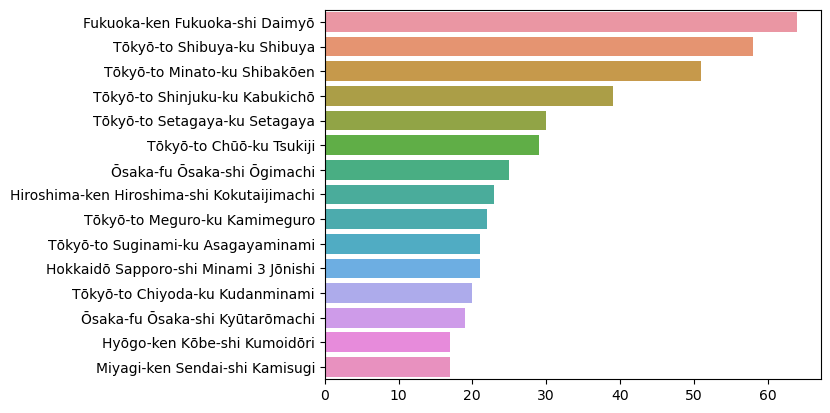

In [101]:
restaurants_per_area_top15 = restaurants_per_area[:15]
sns.barplot(y= restaurants_per_area_top15.index, x= restaurants_per_area_top15.values)
plt.show()

In [128]:
air_store

,store_id,air_genre_name,air_area_name,latitude,longitude,restaurants_per_area
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,17
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,17
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,17
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,17
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,51
...,...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,58
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,58
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,58
827,air_7514d90009613cd6,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,21


In [175]:
import folium

m = folium.Map((air_store['latitude'][100], air_store['longitude'][100]),zoom_start=6)
cluster = MarkerCluster().add_to(m)

for i in air_store.index:
    sub_lat =  air_store.loc[i, 'latitude']
    sub_long = air_store.loc[i, 'longitude']

    #지도에 데이터 찍어서 보여주기
    folium.Marker(location = [sub_lat,sub_long]).add_to(cluster)

m